# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import os
import urllib.request
import zipfile

SOURCE_URL = 'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip'
DATA_DIR = 'data'

def download_data_set(url, directory, filename):
    if not os.path.isdir(directory):
        os.makedirs(directory)
    
    filepath = os.path.join(directory, filename)

    if not os.path.isfile(filepath):
        print('Downloading data set...')
        urllib.request.urlretrieve(url, filepath)
        filestat = os.stat(filepath)
        size = filestat.st_size
        print('Successfully downloaded {} ({} bytes)'.format(filename, size, 'bytes.'))
    else:
        print('Dataset {} already downloaded'.format(filename))

    return filepath

def read_data_set(url = SOURCE_URL, destination = DATA_DIR):
    filepath = download_data_set(url, destination, 'traffic-signs-data.zip')
    
    train_path = os.path.join(destination, 'train.p')
    valid_path = os.path.join(destination, 'valid.p')
    test_path  = os.path.join(destination, 'test.p')
    
    if not all(map(os.path.isfile, [train_path, valid_path, test_path])):
        print('Extracting pickle files...')
        compressed_file = zipfile.ZipFile(filepath)
        compressed_file.extractall(destination)
        pickle_files = list(filter(lambda name: name.endswith('.p'), os.listdir(destination)))
        print('Successfully extracted ', pickle_files)
    
    return train_path, valid_path, test_path

# Loads the training, validation and testing files
training_file, validation_file, testing_file = read_data_set()

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

Dataset traffic-signs-data.zip already downloaded


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [3]:
import pandas
import matplotlib.pyplot as plt

%matplotlib inline

def read_labels_map(filepath = 'signnames.csv'):
    return pandas.read_csv(filepath).as_matrix()

labels_map = read_labels_map()

def plot_images(x, y, indeces, cols = 5):
    rows = len(indeces) // cols
    
    plt.figure(figsize = (15, 2))
    
    for i, index in enumerate(indeces):
        plt.subplot(rows, cols, i + 1)
        plt.title(y[index], fontsize=14, fontweight='bold')
        plt.text(16, 34, labels_map[y[index]][1],
            verticalalignment='top', 
            horizontalalignment='center',
            color='black', fontsize=10)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(x[index])

    plt.tight_layout()
    plt.show()

def plot_random_samples(x, y, num = 5, from_index = 0):
    
    samples = np.random.randint(from_index, len(x), size=num)
    
    plot_images(x, y, samples)
    
    return samples

Let us plot some random images from the **training set**:

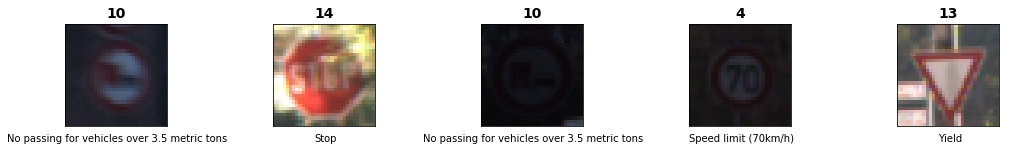

array([18200, 29612, 18624,  7390, 22389])

In [4]:
plot_random_samples(X_train, y_train)

Now let us have a look at the **validation** and **testing** set:

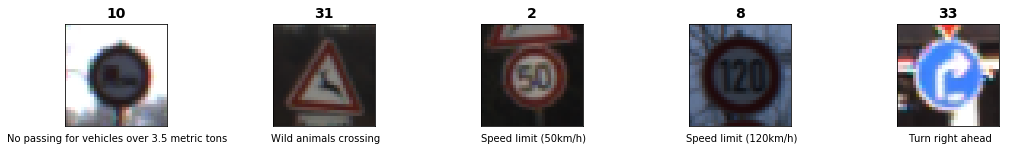

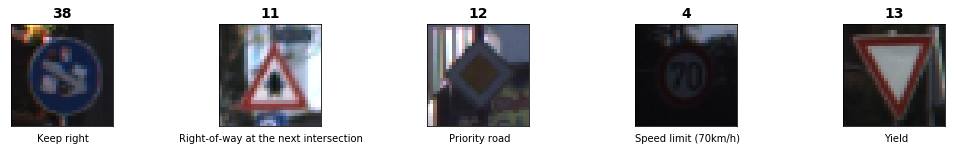

array([7943, 9012,  707, 5755, 4740])

In [5]:
plot_random_samples(X_valid, y_valid)
plot_random_samples(X_test, y_test)

Looking at the images we can notice that there is a brightness shift, we may want to normalize the images or play around with the diffferent color channels in a pre-processing step.

Let us now try to plot the distribution on a bar chart:

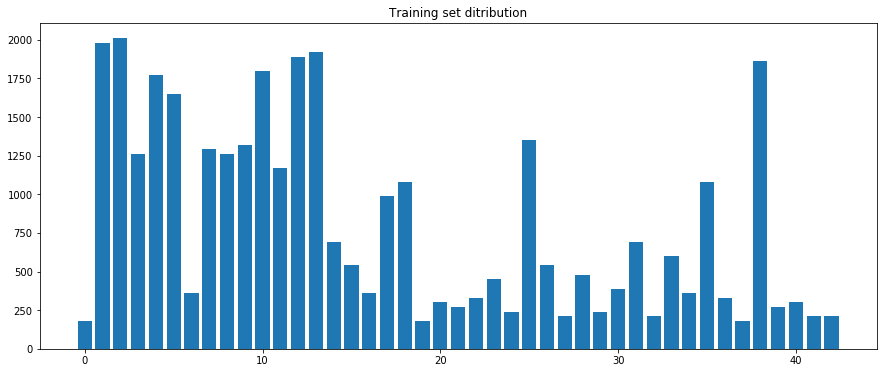

In [6]:
def plot_distribution(y, title):
    classes, count = np.unique(y, return_counts=True)
    plt.figure(figsize = (15, 6))
    plt.title(title)
    plt.bar(classes, count)
    plt.show()

plot_distribution(y_train, 'Training set ditribution')
    

The ditribution of the classes is not uniform and several contains very few examples, this may lead to poor perfomance on any model. Already from this we could think of augmenting the dataset. Let us have a look at the distribution of the validation and testing set:

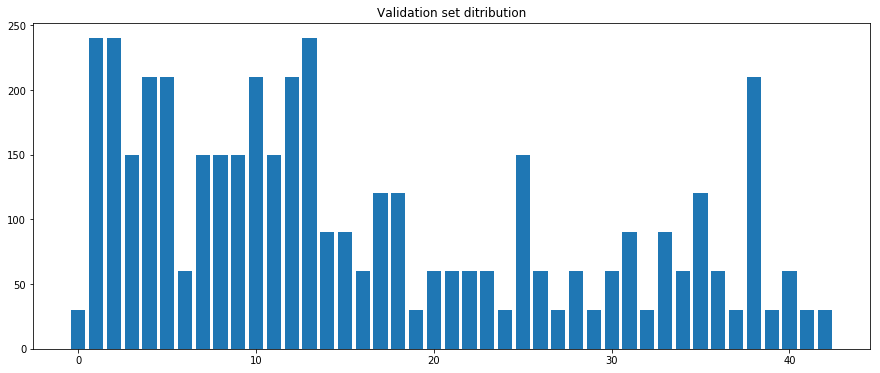

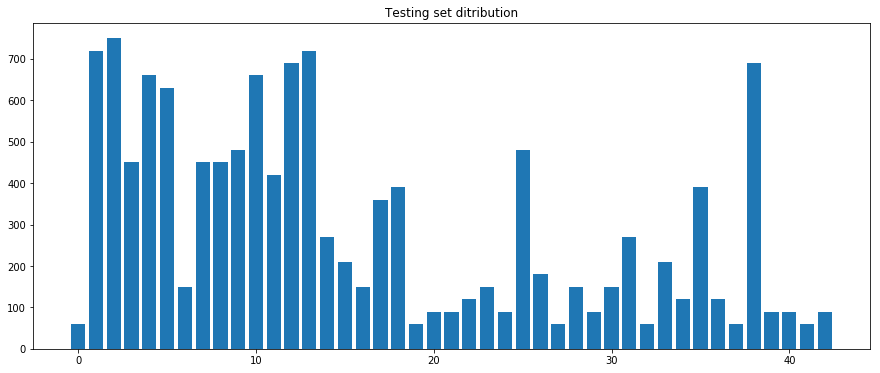

In [7]:
plot_distribution(y_valid, 'Validation set ditribution')
plot_distribution(y_test, 'Testing set ditribution')

We can notice that the distribution is more or less the same among the various data sets.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [8]:
import cv2

def zoom_image(img):
    row, col, _ = img.shape
    
    x1 = np.random.uniform(0, col * .15)
    y1 = np.random.uniform(0, row * .15)
    x2 = np.random.uniform(col * .85, col)
    y2 = np.random.uniform(row * .85, row)
    
    pts1 = np.float32([[x1, y1],[x2, y1],[x1, y2],[x2, y2]])
    pts2 = np.float32([[0, 0],[row, 0],[0, col],[row, col]])

    zoom_m = cv2.getPerspectiveTransform(pts1, pts2)

    return cv2.warpPerspective(img, zoom_m, (col, row))

def translate_image(img, max_trans = 0.2):
    row, col, _ = img.shape

    trans_x = np.random.uniform(-max_trans * row, max_trans * col)
    trans_y = np.random.uniform(-max_trans * col, max_trans * col)

    trans_m = np.float32([[1, 0, trans_x],[0, 1, trans_y]])
    
    return cv2.warpAffine(img, trans_m, (col, row))
    
def rotate_image(img, max_angle = 20):
    row, col, _ = img.shape

    angle = np.random.uniform(-max_angle, max_angle)
    
    rot_m = cv2.getRotationMatrix2D((row / 2, col / 2), angle, 1)

    return cv2.warpAffine(img, rot_m, (col, row))

def random_transform(img):
    # Select a random mask of transforms to apply
    select = np.random.randint(0, 2, (1, 3))[0]
    if (np.sum(select) == 0):
        # Applies at least one transform
        select[np.random.randint(0, 3)] = 1
    if select[0] == 1:
        img = rotate_image(img)
    if select[1] == 1:
        img = translate_image(img)
    if select[2] == 1:
        img = zoom_image(img)
    return img

From the previous section we can notice that the distribution of the various classes in the dataset is not very uniform, there are classes with very few examples. Given the nature of the dataset a first step that we can take is to augment the data generating fake images applying random transformations:

In [9]:
from tqdm import tqdm

def augment_dataset(X, y, factor = 2):
    
    print("Generating new images with a factor of", factor)
    
    additional_x = []
    additional_y = []
    
    classes, count = np.unique(y, return_counts = True)
    
    # Computes the mean to be used as baseline
    mean = np.mean(count) 
    for cls in tqdm(classes):
        class_images = np.where(y == cls)
        curr_count = count[cls]
        class_factor = factor
        if curr_count < mean:
            class_factor = (mean / curr_count * factor).astype('uint32')
        for index in class_images[0]:
            for i in range(class_factor - 1):
                additional_x.append(random_transform(X[index]))
                additional_y.append(cls)
    
    additional_x = np.array(additional_x)
    additional_y = np.array(additional_y)
    
    print("Total generated images: ", len(additional_x))
    
    classes, new_count = np.unique(additional_y, return_counts = True)
    
    for cls in classes:
        print("Generated images for class {}: {} (Prev: {})".format(cls, new_count[cls], count[cls]))
    
    X = np.concatenate((X, additional_x), axis = 0)
    y = np.concatenate((y, additional_y), axis = 0)
    
    return X, y

def load_or_augment(X, y, data_dir = DATA_DIR, ForceGenerate = True):
    
    filename = os.path.join(data_dir, 'train_augmented.p')
    
    if not ForceGenerate and os.path.isfile(filename):
        print('Augmented dataset already generated, loading from pickle file.')
        
        with open(filename, 'rb') as f:
            dataset = pickle.load(f)
        
        X, y = dataset['features'], dataset['labels']
    else:
        X, y = augment_dataset(X, y)

        print("Saving augmented dataset.")

        dataset = {
            'features': X,
            'labels': y
        }
        
        with open(filename, 'wb') as f:   
            pickle.dump(dataset, f, protocol = pickle.HIGHEST_PROTOCOL)
    
    return X, y

X_train_new, y_train_new = load_or_augment(X_train, y_train)

print("Total number of images: {} (Prev: {})".format(len(X_train_new), len(X_train)))

Generating new images with a factor of 2


100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.36it/s]


Total generated images:  52769
Generated images for class 0: 1260 (Prev: 180)
Generated images for class 1: 1980 (Prev: 1980)
Generated images for class 2: 2010 (Prev: 2010)
Generated images for class 3: 1260 (Prev: 1260)
Generated images for class 4: 1770 (Prev: 1770)
Generated images for class 5: 1650 (Prev: 1650)
Generated images for class 6: 1080 (Prev: 360)
Generated images for class 7: 1290 (Prev: 1290)
Generated images for class 8: 1260 (Prev: 1260)
Generated images for class 9: 1320 (Prev: 1320)
Generated images for class 10: 1800 (Prev: 1800)
Generated images for class 11: 1170 (Prev: 1170)
Generated images for class 12: 1890 (Prev: 1890)
Generated images for class 13: 1920 (Prev: 1920)
Generated images for class 14: 690 (Prev: 690)
Generated images for class 15: 540 (Prev: 540)
Generated images for class 16: 1080 (Prev: 360)
Generated images for class 17: 990 (Prev: 990)
Generated images for class 18: 1080 (Prev: 1080)
Generated images for class 19: 1260 (Prev: 180)
Generated

We can now view some of the generated images:

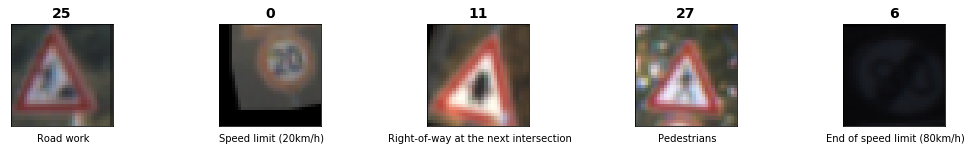

array([67474, 35460, 51788, 70325, 45803])

In [12]:
plot_random_samples(X_train_new, y_train_new, from_index = len(X_train))

And the current distribution of the dataset:

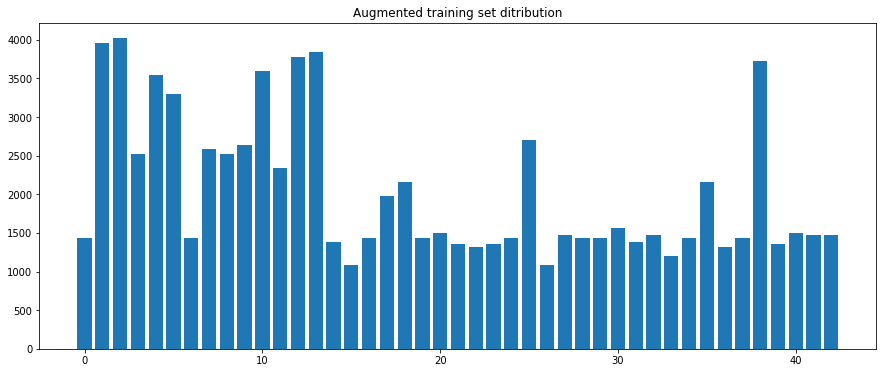

In [13]:
plot_distribution(y_train_new, 'Augmented training set ditribution')

X_train, y_train = X_train_new, y_train_new

Next we proceed preprocessing the images in the dataset:

In [14]:
# Contrast Limited Adaptive Histogram Equalization
CLAHE = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))

def normalize_data(X, a = -.5, b = .5, X_min = 0, X_max = 255):
    return a + ((X - X_min) * (b - a)) / (X_max - X_min)
    #return (X - 128.)/128.
    
def hist_equalize(img, clahe = None):
    # Convert to LAB color space
    converted = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    
    # Equalize the histogram on the L channel only
    converted[:,:,0] = cv2.equalizeHist(converted[:,:,0]) if clahe is None else clahe.apply(converted[:,:,0])

    return cv2.cvtColor(converted, cv2.COLOR_LAB2RGB)

def preprocess_image(img):
    img = hist_equalize(img, clahe = CLAHE)
    return img

def preprocess_data(X, normalize = True):
    images = []
    
    for img in X:
        images.append(preprocess_image(img))
    
    images = np.array(images)
    
    images = normalize_data(images) if normalize else images
    
    return images

X_train_p = preprocess_data(X_train, normalize = False)

Given that a lot of images are very dark we apply a histogram equalization to fix the contrast, from https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html we can try using Contrast Limited Adaptive Histogram Equalization (CLAHE) that seems to yield better results:

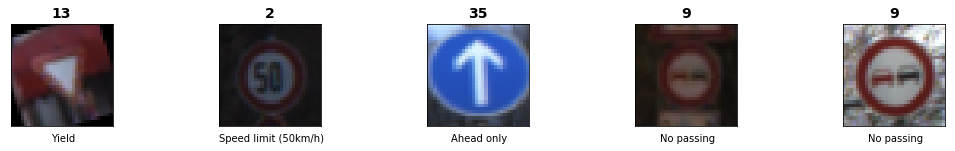

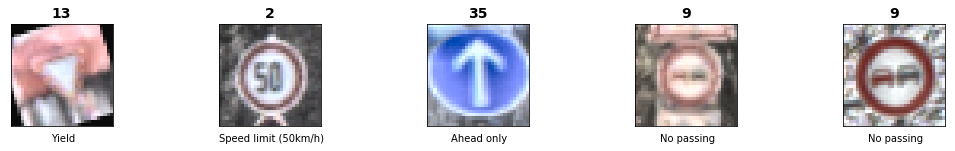

In [15]:
indices = plot_random_samples(X_train, y_train)

plot_images(X_train_p, y_train, indices)

In the previous step we didn't apply any normalization on the data in order to show the images, let us apply now a normalization step:

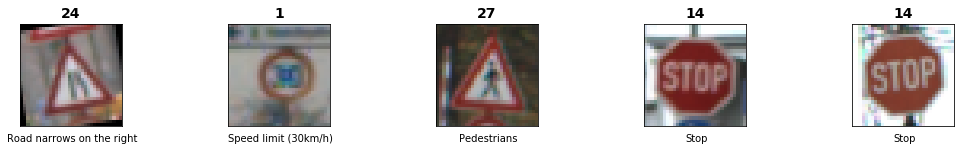

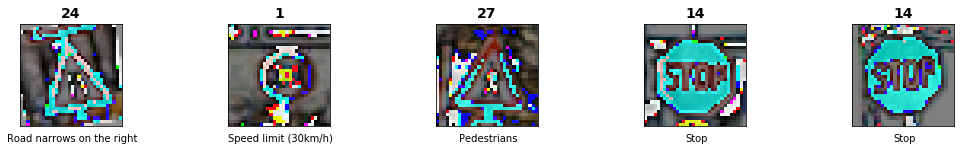

In [16]:
X_train_n = normalize_data(X_train_p)

indices = plot_random_samples(X_train, y_train)

plot_images(X_train_n, y_train, indices)

We can now apply the preprocessing to the validation and testing sets as well:

In [17]:
X_train = X_train_n
X_valid = preprocess_data(X_valid)
X_test = preprocess_data(X_test)

Before training we need to make sure that the data is shuffled:

In [18]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)


### Model Architecture

We have various options, let us try with a simple model first, based on LeNet architecture:

In [19]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

tf.reset_default_graph()

W_MEAN = 0
W_DEV = 0.1

def weight(input_channels, output_channels, filter_size = None):
    if filter_size is None:
        return tf.Variable(tf.truncated_normal(shape = (input_channels, output_channels), mean = W_MEAN, stddev = W_DEV))
    else:
        return tf.Variable(tf.truncated_normal([filter_size, filter_size, input_channels, output_channels], mean = W_MEAN, stddev = W_DEV))

def bias(size):
    return tf.Variable(tf.zeros(size))

def fully_connected(x, W, b, Relu = True):
    x = tf.matmul(x, W)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) if Relu else x

def convolution_relu(x, W, b, s = 1, padding = 'VALID'):
    x = tf.nn.conv2d(x, W, strides = [1, s, s, 1], padding = padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def max_pooling(x, k = 2, padding = 'VALID'):
    return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = padding)

def lenet(x):
    '''
    Input: 32x32x3
    L1: 
    - Conv: 5x5x6
    - MaxPooling
    L2:
    - Conv: 5x5x16
    - MaxPooling
    - Flatten
    L4:
    - FC: 400x120
    L5:
    - FC: 120x84
    L6:
    - FC: 84x43
    '''
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    x = convolution_relu(x, weight(3, 6, 5), bias(6))
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    x = max_pooling(x, k = 2)
    # Layer 2: Convolutional. Input = 14x14x6. Output = 10x10x16.
    x = convolution_relu(x, weight(6, 16, 5), bias(16))
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    x = max_pooling(x, k = 2)
    # Flatten. Input = 5x5x16. Output = 400.
    x = flatten(x)
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    x = fully_connected(x, weight(400, 120), bias(120))
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    x = fully_connected(x, weight(120, 84), bias(84))
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = fully_connected(x, weight(84, n_classes), bias(n_classes), Relu = False)
    
    return logits

def lenet_v2(x):
    '''
    Input: 32x32x3
    L1: 
    - Conv: 3x3x16
    - MaxPooling
    L2:
    - Conv: 3x3x32
    - MaxPooling
    L3:
    - Conv: 3x3x128
    - MaxPooling
    - Flatten
    L4:
    - FC: 512x256
    L5:
    - FC: 256x128
    L6:
    - FC: 128x43
    '''
    # new_height = (input_height - filter_height + 2 * P)/S + 1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x16.
    x = convolution_relu(x, weight(3, 16, 3), bias(16))
    # Pooling. Input = 30x30x16. Output = 15x15x16.
    x = max_pooling(x, k = 2)
    # Layer 2: Convolutional. Input = 15x15x16. Output = 13x13x32.
    x = convolution_relu(x, weight(16, 32, 3), bias(32))
    # Pooling. Input = 13x13x32. Output = 6x6x32.
    x = max_pooling(x, k = 2)
    # Layer 3: Convolutional. Input = 6x6x32. Output = 4x4x128.
    x = convolution_relu(x, weight(32, 128, 3), bias(128))
    # Pooling. Input = 4x4x128. Output = 2x2x128.
    x = max_pooling(x, k = 2)
    # Flatten. Input = 2x2x128. Output = 512.
    x = flatten(x)
    # Layer 4: Fully Connected. Input = 512. Output = 256.
    x = fully_connected(x, weight(512, 256), bias(256))
    # Layer 5: Fully Connected. Input = 256. Output = 128.
    x = fully_connected(x, weight(256, 128), bias(128))
    # Layer 6: Fully Connected. Input = 128. Output = 43.
    logits = fully_connected(x, weight(128, n_classes), bias(n_classes), Relu = False)
    
    return logits

def lenet_v3(x):
    '''
    Input: 32x32x3
    L1: 
    - Conv: 3x3x32
    - MaxPooling
    L2:
    - Conv: 3x3x64
    - MaxPooling
    L3:
    - Conv: 3x3x128
    - MaxPooling
    - Flatten
    L4:
    - FC: 512x256
    L5:
    - FC: 256x128
    L6:
    - FC: 128x43
    '''
    # new_height = (input_height - filter_height + 2 * P)/S + 1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x32.
    x = convolution_relu(x, weight(3, 32, 3), bias(32))
    # Pooling. Input = 30x30x16. Output = 15x15x16.
    x = max_pooling(x, k = 2)
    # Layer 2: Convolutional. Input = 15x15x16. Output = 13x13x64.
    x = convolution_relu(x, weight(32, 64, 3), bias(64))
    # Pooling. Input = 13x13x32. Output = 6x6x32.
    x = max_pooling(x, k = 2)
    # Layer 3: Convolutional. Input = 6x6x32. Output = 4x4x128.
    x = convolution_relu(x, weight(64, 128, 3), bias(128))
    # Pooling. Input = 4x4x128. Output = 2x2x128.
    x = max_pooling(x, k = 2)
    # Flatten. Input = 2x2x128. Output = 512.
    x = flatten(x)
    # Layer 4: Fully Connected. Input = 512. Output = 256.
    x = fully_connected(x, weight(512, 256), bias(256))
    # Layer 5: Fully Connected. Input = 256. Output = 128.
    x = fully_connected(x, weight(256, 128), bias(128))
    # Layer 6: Fully Connected. Input = 128. Output = 43.
    logits = fully_connected(x, weight(128, n_classes), bias(n_classes), Relu = False)
    
    return logits

def custom_net(x):
    '''
    Input: 32x32x3
    L1: 
    - Conv: 5x5x8
    L2:
    - Conv: 5x5x8
    - MaxPooling
    L3:
    - Conv: 3x3x16
    L4:
    - Conv: 3x3x16
    - MaxPooling
    L5:
    - Conv: 3x3x64
    - Flatten
    L6:
    - FC: 256x1024
    L7:
    - FC: 1024x512
    L7:
    - FC: 512x43
    '''
    # new_height = (input_height - filter_height + 2 * P)/S + 1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x8.
    x = convolution_relu(x, weight(3, 8, 5), bias(8))
    # Layer 2: Convolutional. Input = 28x28x8. Output = 26x26x32.
    x = convolution_relu(x, weight(8, 8, 5), bias(8))
    # Pooling. Input = 26x26x8. Output = 13x13x8.
    x = max_pooling(x, k = 2)
    # Layer 3: Convolutional. Input = 13x13x8. Output = 11x11x16.
    x = convolution_relu(x, weight(8, 16, 3), bias(16))
    # Layer 4: Convolutional. Input = 11x11x16. Output = 9x9x16.
    x = convolution_relu(x, weight(16, 16, 3), bias(16))
    # Pooling. Input = 9x9x16. Output = 4x4x16.
    x = max_pooling(x, k = 2)
    # Layer 5: Convolutional. Input = 4x4x16. Output = 2x2x64.
    x = convolution_relu(x, weight(16, 64, 3), bias(64))
    # Flatten. Input = 2x2x64. Output = 1024.
    x = flatten(x)
    # Layer 6: Fully Connected. Input = 256. Output = 1024.
    x = fully_connected(x, weight(256, 1024), bias(1024))
    # Layer 7: Fully Connected. Input = 1024. Output = 512.
    x = fully_connected(x, weight(1024, 512), bias(512))
    # Layer 8: Fully Connected. Input = 512. Output = 43.
    logits = fully_connected(x, weight(512, n_classes), bias(n_classes), Relu = False)
    
    return logits

def custom_net_v2(x):
    '''
    Input: 32x32x3
    L1: 
    - Conv: 3x3x32
    L2:
    - Conv: 3x3x32
    - MaxPooling
    L3:
    - Conv: 3x3x64
    L4:
    - Conv: 3x3x64
    - MaxPooling
    L5:
    - Conv: 3x3x128
    - Flatten
    L6:
    - FC: 1152x1024
    L7:
    - FC: 1024x512
    L7:
    - FC: 512x43
    '''
    # new_height = (input_height - filter_height + 2 * P)/S + 1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x32.
    x = convolution_relu(x, weight(3, 32, 3), bias(32))
    # Layer 2: Convolutional. Input = 30x30x32. Output = 28x28x32.
    x = convolution_relu(x, weight(32, 32, 3), bias(32))
    # Pooling. Input = 28x28x32. Output = 14x14x32.
    x = max_pooling(x, k = 2)
    # Layer 3: Convolutional. Input = 14x14x32. Output = 12x12x64
    x = convolution_relu(x, weight(32, 64, 3), bias(64))
    # Layer 4: Convolutional. Input = 12x12x64. Output = 10x10x64.
    x = convolution_relu(x, weight(64, 64, 3), bias(64))
    # Pooling. Input = 10x10x64. Output = 5x5x64.
    x = max_pooling(x, k = 2)
    # Layer 5: Convolutional. Input = 5x5x64. Output = 3x3x128.
    x = convolution_relu(x, weight(64, 128, 3), bias(128))
    # Flatten. Input = 3x3x128. Output = 1152.
    x = flatten(x)
    # Layer 6: Fully Connected. Input = 1152. Output = 1024.
    x = fully_connected(x, weight(1152, 1024), bias(1024))
    # Layer 7: Fully Connected. Input = 1024. Output = 512.
    x = fully_connected(x, weight(1024, 512), bias(512))
    # Layer 8: Fully Connected. Input = 512. Output = 43.
    logits = fully_connected(x, weight(512, n_classes), bias(n_classes), Relu = False)
    
    return logits
    

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [ ]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
learn_rate = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

logits = lenet_v3(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learn_rate)

training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
import time

MODEL_DIR = 'models'
EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.001

def evaluate(X_data, y_data, batch_size = BATCH_SIZE):
    num_examples = len(X_data)
    total_loss = 0
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset + batch_size], y_data[offset:offset + batch_size]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y})
        total_loss += (loss * len(batch_x))
        total_accuracy += (accuracy * len(batch_x))
    return total_loss / num_examples, total_accuracy / num_examples

def train(X_train, y_train, X_validation, y_validation, epochs = EPOCHS, batch_size = BATCH_SIZE, learning_rate = LEARNING_RATE, restore = False):
    
    # Used later on for plotting
    valid_losses = []
    valid_accuracy = []
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        
        if restore:
            saver.restore(sess, tf.train.latest_checkpoint(MODEL_DIR))
            print("Checkpoint restored")
        else:        
            sess.run(tf.global_variables_initializer())

        num_examples = len(X_train)

        print("Training on {} samples (Epochs: {}, Batch Size: {}, Learning Rate: {})...".format(num_examples, epochs, batch_size, learning_rate))
        print()
        
        start = time.time()
        
        for i in range(epochs):
            X_train, y_train = shuffle(X_train, y_train)
            
            start_ep = time.time()
            for offset in range(0, num_examples, batch_size):
                end = offset + batch_size
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, learn_rate: learning_rate})

            valid_loss, valid_acc = evaluate(X_validation, y_validation, batch_size = batch_size)
            
            valid_losses.append(valid_loss)
            valid_accuracy.append(valid_acc)
            
            elapsed_ep = time.time() - start_ep
            print("EPOCH {} ({:.1f} s): Validation Loss: = {:.3f},  Validation Accuracy = {:.3f}".format(i+1, elapsed_ep, valid_loss, valid_acc))

        elapsed = time.time() - start
        print("Training finished ({:.1f} s)".format(elapsed))
        saver.save(sess, os.path.join(MODEL_DIR, 'model.ckpt'))
        print("Model saved")
        return valid_losses, valid_accuracy

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

valid_l, valid_a = train(X_train, y_train, X_valid, y_valid, restore = False)

# Original Dataset

# LeNet N (128): 128 0.001                               -> 0.9  (12 EPOCHS)
# LeNet N (.1, .9): 128 0.001                            -> 0.89 (12 EPOCHS)
# LeNet N (-.5, .5): 128 0.001                           -> 0.89 (12 EPOCHS)
# LeNet N (-.5, -.5) + Hist Equal: 128 0.001             -> 0.91 (12 EPOCHS) / 0.903
# LeNet N (128) + Hist Equal (CLAHE): 128 0.001          -> 0.939 (12 EPOCHS) 
# LeNet N (-.5, -.5) + Hist Equal (CLAHE): 128 0.001     -> 0.943 (12 EPOCHS) / 0.928
# LeNet v2 N (-.5, -.5) + Hist Equal (CLAHE): 128 0.001  -> 0.968 (24 EPOCHS) / 0.964
# LeNet v3 N (-.5, -.5) + Hist Equal (CLAHE): 128 0.001  -> 0.975 (20 EPOCHS) / 0.964

# Augmented Dataset

# LeNet v3 ->


In [ ]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(MODEL_DIR))
    train_loss, train_acc = evaluate(X_train, y_train)
    print("Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(train_loss, train_acc))

plt.plot(valid_l, '', valid_a, '')
plt.title("Validation set loss/accuracy")
plt.show()

In [ ]:
def test(X_data, y_data):
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint(MODEL_DIR))

        test_loss, test_accuracy = evaluate(X_data, y_data)
        print("Test Loss: {:.3f}, Test Accuracy: {:.3f}".format(test_loss, test_accuracy))
        
test(X_test, y_test)

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")